Step 14: Channel Flow with Navier–Stokes
----
***

The only difference between this step and the previous step is that we are going to add a source term to the $u$-momentum equation, to mimic the effect of a pressure-driven channel flow. Here are our modified Navier–Stokes equations:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)+F$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y} \right) - \frac{\partial u}{\partial x}\frac{\partial u}{\partial x}-2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}-\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

The initial condition is $u, v, p=0$ everywhere, and at the boundary conditions are:

$u, v, p$ are periodic on $x=0,2$

$u, v =0$ at $y =0,2$

$\frac{\partial p}{\partial y}=0$ at $y =0,2$

$F=1$ everywhere.

Let's begin by importing our usual run of libraries:


In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D

In step 13, we isolated a portion of our transposed equation to make it easier to parse and we're going to do the same thing here.  One thing to note is that we have periodic boundary conditions throughout this grid, so we need to explicitly calculate the values at the leading and trailing edge of our `u` vector.

In [2]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                                      (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                            ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                            2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                                 (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                            ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    # Periodic BC Pressure @ x = 2
    b[1:-1, -1] = (rho * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                          2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

    # Periodic BC Pressure @ x = 0
    b[1:-1, 0] = (rho * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                         2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))
    
    return b

We'll also define a Pressure Poisson iterative function, again like we did in Step 11.  Once more, note that we have to include the periodic boundary conditions at the leading and trailing edge.  We also have to specify the boundary conditions at the top and bottom of our grid.  


In [3]:
def pressure_poisson_periodic(p, dx, dy):
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 1:-1])

        # Periodic BC Pressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # Periodic BC Pressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # Wall boundary conditions, pressure
        p[-1, :] =p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :] = p[1, :]  # dp/dy = 0 at y = 0
    
    return p

In [4]:
##variable declarations
nx = 41
ny = 41
#nt = 10
nit = 80 
#c = 1
H = 2
dx = H / (nx - 1)
dy = H / (ny - 1)
x = np.linspace(0, H, nx)
y = np.linspace(0, H, ny)
X, Y = np.meshgrid(x, y)


##physical variables
rho = 2
nu = .01
mu = nu * rho

F = 1
dpdx = F * rho 
dt = .1

#initial conditions
u = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

p = np.ones((ny, nx))
pn = np.ones((ny, nx))

b = np.zeros((ny, nx))

For the meat of our computation, we're going to reach back to a trick we used in Step 11 for Laplace's Equation.  We're interested in what our grid will look like once we've reached a near-steady state.  We can either specify a number of timesteps `nt` and increment it until we're satisfied with the results, or we can tell our code to run until the difference between two consecutive iterations is very small.  

We also have to manage **8** separate boundary conditions for each iteration.  The code below writes each of them out explicitly.  If you're interested in a challenge, you can try to write a function which can handle some or all of these boundary conditions.  If you're interested in tackling that, you should probably read up on Python [dictionaries](http://docs.python.org/2/tutorial/datastructures.html#dictionaries).  

In [5]:
udiff = 1
stepcount = 0

while udiff > 1e-6:
    un = u.copy()
    vn = v.copy()

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy)

    u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                     dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     nu * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                     un[1:-1, 1:-1] * dt / dx * 
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / dy * 
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * rho * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    # Periodic BC u @ x = 2     
    u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                  (un[1:-1, -1] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / dy * 
                  (un[1:-1, -1] - un[0:-2, -1]) -
                   dt / (2 * rho * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   nu * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

    # Periodic BC u @ x = 0
    u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * rho * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  nu * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

    # Periodic BC v @ x = 2
    v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * rho * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   nu * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

    # Periodic BC v @ x = 0
    v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * rho * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  nu * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


    # Wall BC: u,v = 0 @ y = 0,2
    u[0, :] = 0
    u[-1, :] = 0
    v[0, :] = 0
    v[-1, :]=0
    
    udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
    #print(udiff)
    stepcount += 1

You can see that we've also included a variable `stepcount` to see how many iterations our loop went through before our stop condition was met.  

In [6]:
print(stepcount)

3159


If you want to see how the number of iterations increases as our `udiff` condition gets smaller and smaller, try defining a function to perform the `while` loop written above that takes an input `udiff` and outputs the number of iterations that the function runs.  

For now, let's look at our results.  We've used the quiver function to look at the cavity flow results and it works well for channel flow, too.  

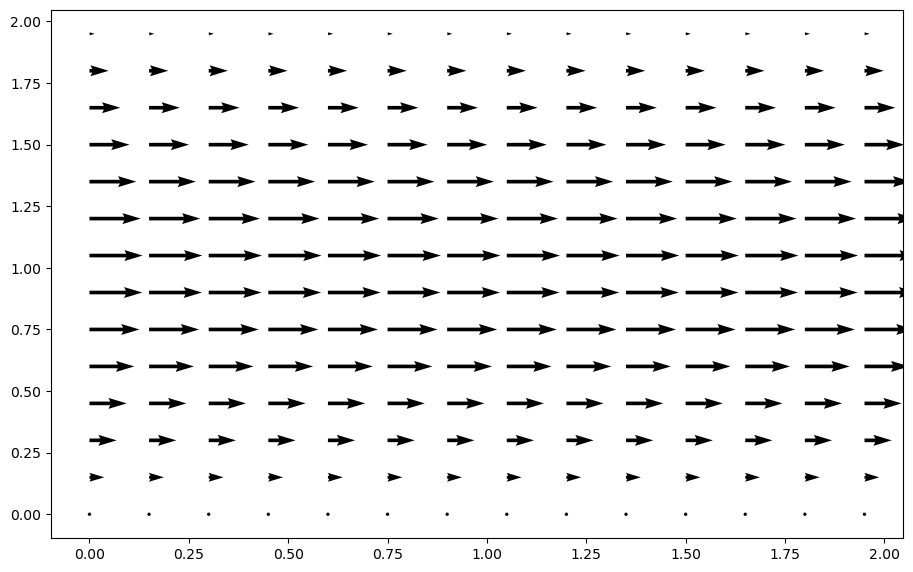

In [7]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.quiver(X[::3, ::3], Y[::3, ::3], u[::3, ::3], v[::3, ::3]);

The structures in the `quiver` command that look like `[::3, ::3]` are useful when dealing with large amounts of data that you want to visualize.  The one used above tells `matplotlib` to only plot every 3rd data point.  If we leave it out, you can see that the results can appear a little crowded.  

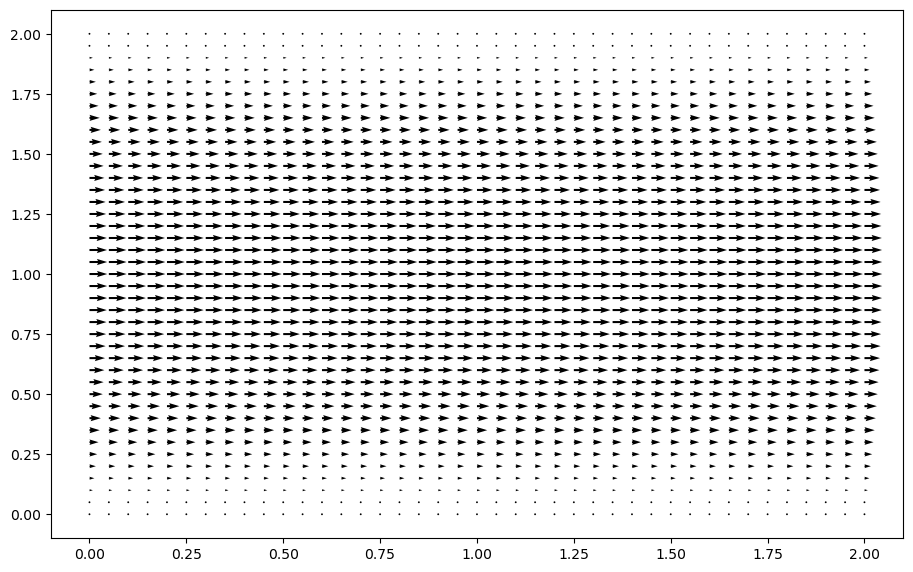

In [8]:
fig = plt.figure(figsize = (11,7), dpi=100)
plt.quiver(X, Y, u, v);

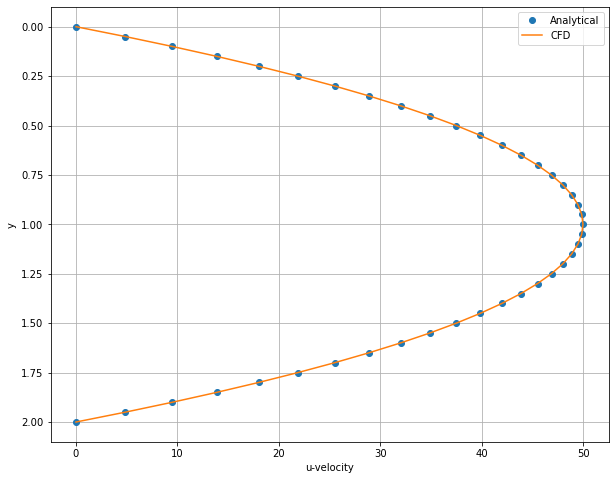

In [9]:
u_ana = -dpdx / (2*mu) * y * (y - H)

# Plotting
plt.figure(figsize=(10,8))

plt.plot(u_ana, y, 'o', label='Analytical') # 
plt.plot(u[:,int(nx/2)], y, label='CFD') # 
plt.xlabel('u-velocity')
plt.ylabel('y')
#plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()

##### What is the meaning of the $F$ term? 

Step 12 is an exercise demonstrating the problem of flow in a channel or pipe. If you recall from your fluid mechanics class, a specified pressure gradient is what drives Poisseulle flow. 

Recall the $x$-momentum equation:

$$\frac{\partial u}{\partial t}+u \cdot \nabla u = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \nabla^2 u$$

What we actually do in Step 12 is split the pressure into steady and unsteady components $p=P+p'$. The applied steady pressure gradient is the constant $ -\frac{1}{\rho}\frac{\partial p}{\partial x}=F$ (interpreted as a source term), and the unsteady component is $\frac{\partial p'}{\partial x}$. So the pressure that we solve for in Step 12 is actually $p'$, which for a steady flow is in fact equal to zero everywhere.

<b>Why did we do this?</b>

Note that we use periodic boundary conditions for this flow. For a flow with a constant pressure gradient, the value of pressure on the left edge of the domain must be different from the pressure at the right edge. So we cannot apply periodic boundary conditions on the pressure directly. It is easier to fix the gradient and then solve for the perturbations in pressure.

<b>Shouldn't we always expect a uniform/constant $p'$ then?</b>

That's true only in the case of steady laminar flows. At high Reynolds numbers, flows in channels can become turbulent, and we will see unsteady fluctuations in the pressure, which will result in non-zero values for $p'$. 

In step 12, note that the pressure field itself is not constant, but it's the pressure perturbation field that is. The pressure field varies linearly along the channel with slope equal to the pressure gradient. Also, for incompressible flows, the absolute value of the pressure is inconsequential.


### Try to use Chorin's projection method to solve this problem:

Solution strategy:   (Projection Method: Chorin's Splitting)

https://www.youtube.com/watch?v=BQLvNLgMTQE&t=106s

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

$$\frac{\partial \vec{v}^*}{\partial t}+(\vec{v}^*\cdot\nabla)\vec{v}^*= \nu \nabla^2\vec{v}^* + \vec{F} $$

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u^*}{\partial x} +\frac{\partial v^*}{\partial y} \right)  \right)$$

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

$$u = u^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial x} $$
$$v = v^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial y} $$
